In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gpytorch.priors import NormalPrior
from gpytorch.kernels import RBFKernel

from mobius import Planner, SequenceGA
from mobius import ProteinEmbedding
from mobius import GPLLModel, ExpectedImprovement
from mobius import LinearPeptideEmulator
from mobius import homolog_scanning, alanine_scanning
from mobius import convert_FASTA_to_HELM, convert_HELM_to_FASTA

# Initialize MHC emulator

In [3]:
pssm_files = ['../data/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-8.txt',
              '../data/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-9.txt',
              '../data/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-10.txt',
              '../data/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-11.txt']
lpe = LinearPeptideEmulator(pssm_files)

# Define lead peptide and create initial peptide batch

In [4]:
lead_peptide = convert_FASTA_to_HELM('HMTEVVRRC')[0]

In [5]:
seed_library = [lead_peptide]

for seq in alanine_scanning(lead_peptide):
    seed_library.append(seq)

for seq in homolog_scanning(lead_peptide):
    seed_library.append(seq)

    if len(seed_library) >= 96:
        print('Reach max. number of peptides allowed.')
        break

Reach max. number of peptides allowed.


In [6]:
pic50_seed_library = lpe.score(seed_library)
seed_library = convert_HELM_to_FASTA(seed_library)

# Initialize protein Language Model (pLM)

In [8]:
pretrained_model_name = 'esm1b_t33_650M_UR50S' # 'Rostlab/prot_t5_xl_uniref50'

finetuning = True
lora_finetuning = False
lora_rank = 8
lora_alpha = lora_rank * 2
    
if finetuning:
    if lora_finetuning:
        # Do all layer, but only Q and V weights
        if 'esm' in pretrained_model_name:
            parameters_to_finetune = ['layers.*.self_attn.q_proj.weight', 'layers.*.self_attn.v_proj.weight']
        elif "Rostlab" in pretrained_model_name:
            parameters_to_finetune = ['encoder.block.*.layer.0.SelfAttention.q', 'encoder.block.*.layer.0.SelfAttention.v']
        else:
            print("Warning: cannot recognize pretrained model. No finetuning!")
            parameters_to_finetune = None
    elif not lora_finetuning:
        # only do last layer Q and V weights
        if 'esm' in pretrained_model_name:
            parameters_to_finetune = ['layers.32.self_attn.q_proj.weight', 'layers.32.self_attn.v_proj.weight']
        elif "Rostlab" in pretrained_model_name:
            parameters_to_finetune = ['encoder.block.23.layer.0.SelfAttention.q.weight', 'encoder.block.23.layer.0.SelfAttention.v.weight']
        else:
            print("Warning: cannot recognize pretrained model. No finetuning!")
            parameters_to_finetune = None
            

In [ ]:
if "Rostlab" in pretrained_model_name:
    plm = ProteinEmbedding(pretrained_model_name=pretrained_model_name, embedding_type='avg', 
                           layers_to_finetune=parameters_to_finetune, lora=lora_finetuning, lora_rank=lora_rank, lora_alpha=lora_alpha,
                            model_name='T5EncoderModel', tokenizer_name='T5Tokenizer')
else:
    plm = ProteinEmbedding(pretrained_model_name=pretrained_model_name, embedding_type='avg', 
                           layers_to_finetune=parameters_to_finetune, lora=lora_finetuning, lora_rank=lora_rank, lora_alpha=lora_alpha)


# Define Gaussian Process, acquisition function and GA optimizer

In [8]:
gpmodel = GPLLModel(kernel=RBFKernel(), pretrained_model=plm, noise_prior=NormalPrior(loc=0, scale=1))

In [9]:
yaml_content = """
design:
  monomers:
    default: [A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y]
    APOLAR: [A, F, G, I, L, P, V, W]
    POLAR: [C, D, E, H, K, N, Q, R, K, S, T, M]
    AROMATIC: [F, H, W, Y]
    POS_CHARGED: [K, R]
    NEG_CHARGED: [D, E]
  biopolymers:
    - name: PEPTIDE1
      starting_residue: 1
      length: 9
      positions:
        1-9: default
"""

with open('design_protocol.yaml', 'w') as f:
    f.write(yaml_content)

In [14]:
ei = ExpectedImprovement(gpmodel, maximize=False)
optimizer = SequenceGA(algorithm='GA', period=5, design_protocol_filename='design_protocol.yaml')
ps = Planner(ei, optimizer)

# Run optimization!

In [15]:
peptides = seed_library.copy()
pic50_scores = pic50_seed_library.copy()

# Store data for later analysis
data = [(0, p, s) for p, s in zip(peptides, pic50_scores)]

for i in range(3):
    suggested_peptides, _ = ps.recommend(peptides, pic50_scores.reshape(-1, 1), batch_size=96)

    # Here you can add whatever methods you want to further filter out peptides

    # Virtually test the suggested peptides using the MHC emulator
    # You know the drill now, this is for benchmarking or demonstration
    # purposes only and should be replaced with actual lab experiments.
    pic50_suggested_peptides = lpe.score(convert_FASTA_to_HELM(suggested_peptides))

    peptides = np.concatenate([peptides, suggested_peptides])
    pic50_scores = np.concatenate((pic50_scores, pic50_suggested_peptides), axis=0)
    data.extend([(i + 1, p, s) for p, s in zip(suggested_peptides, pic50_suggested_peptides)])

    best_seq = peptides[np.argmin(pic50_scores)]
    best_pic50 = np.min(pic50_scores)
    print('Best peptide found so far: %s / %.3f' % (best_seq, best_pic50))
    print('')

df = pd.DataFrame(data=data, columns=('iter', 'polymer', 'exp_value'))

n_gen  |  n_eval  |     cv_min    |     cv_avg    |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  0.000000E+00 |  0.1486486486 |  9.64239968253968094 |  8.54086000000000034 |      PEPTIDE1{H.M.T.E.V.V.R.R.L}$$$$V2.0
     2 |      500 |  0.000000E+00 |  0.0640000000 |  1.25694862311931210 | -3.1966939441998E-01 |      PEPTIDE1{F.M.T.E.V.V.C.R.V}$$$$V2.0
     3 |     1000 |  0.000000E+00 |  0.000000E+00 | -9.2990195655305E-02 | -5.1978735568213E-01 |      PEPTIDE1{F.M.M.E.V.V.R.R.V}$$$$V2.0
     4 |     1500 |  0.000000E+00 |  0.000000E+00 | -1.5215198151053E-01 | -5.1978735568213E-01 |      PEPTIDE1{F.M.M.E.V.V.R.R.V}$$$$V2.0
     5 |     2000 |  0.000000E+00 |  0.000000E+00 | -2.2367634241617E-01 | -7.2952968030298E-01 |      PEPTIDE1{H.M.M.E.V.V.L.R.V}$$$$V2.0
     6 |     2500 |  0.000000E+00 |  0.000000E+00 | -2.9100283463950E-01 | -7.2952968030298E-01 |      PEPTIDE1{H.M.M.E.V.V.L.R.V}$$$$V2.0
     7 |     3000 |  0.0000

/scicore/home/schwede/eberha0001/Applications/mambaforge/envs/mm/lib/python3.9/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


n_gen  |  n_eval  |     cv_min    |     cv_avg    |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  0.000000E+00 |  0.0371747212 |  8.39116602316602211 |  6.48700000000000010 |      PEPTIDE1{F.M.M.D.Y.L.F.R.V}$$$$V2.0
     2 |      500 |  0.000000E+00 |  0.000000E+00 |  1.32293128547117300 | -9.3028446134861E-03 |      PEPTIDE1{F.M.M.E.D.V.Y.F.V}$$$$V2.0
     3 |     1000 |  0.000000E+00 |  0.000000E+00 | -1.5249595217820E-04 | -1.0440498149125E-02 |      PEPTIDE1{F.M.M.E.D.L.Y.F.V}$$$$V2.0
     4 |     1500 |  0.000000E+00 |  0.000000E+00 | -2.9101907299329E-04 | -1.1440334988665E-02 |      PEPTIDE1{Y.M.M.E.D.V.F.F.V}$$$$V2.0
     5 |     2000 |  0.000000E+00 |  0.000000E+00 | -5.5748780929289E-04 | -2.3391011897083E-02 |      PEPTIDE1{Y.M.M.D.Y.V.F.E.V}$$$$V2.0
     6 |     2500 |  0.000000E+00 |  0.000000E+00 | -8.2770841123541E-04 | -2.3391011897083E-02 |      PEPTIDE1{Y.M.M.D.Y.V.F.E.V}$$$$V2.0
     7 |     3000 |  0.0000

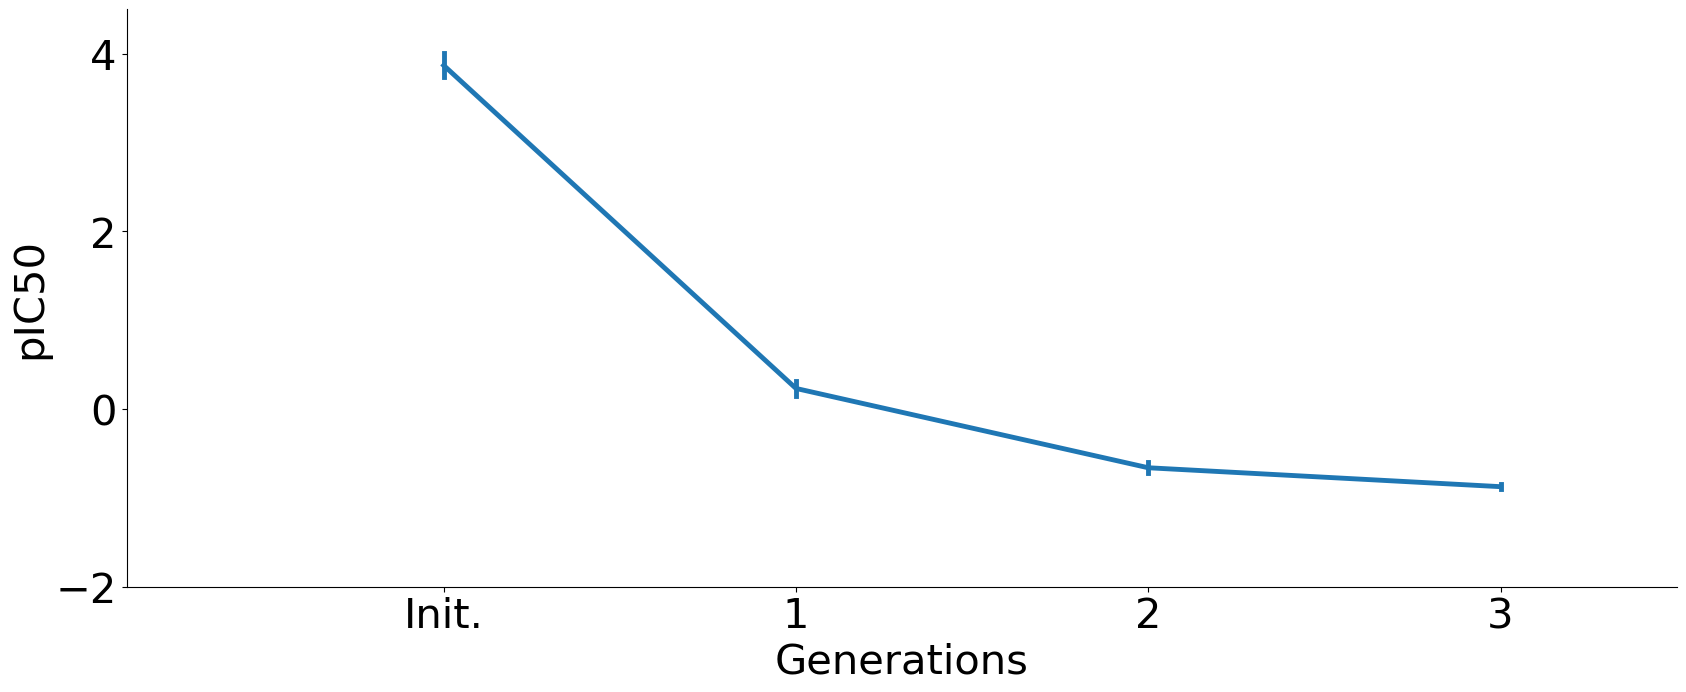

In [43]:
fig, ax = plt.subplots(figsize=(20, 7.5))

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3'})

sns.lineplot(x='iter', y='exp_value', data=df, ax=ax, errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

ax.set_xlim([-0.9, 3.5])
ax.set_ylim([-2, 4.5])
ax.set_ylabel('pIC50', fontsize=30)
ax.set_xlabel('Generations', fontsize=30)
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)

sns.despine()
plt.show()